# 不同超参数的对比分析（包括卷积层数、卷积核大小、不同dilation的选择，batchsize、lr等）选其中至少1-2个进行分析（选做）


Training model with Kernel Size: 3, Layers: 2, Dilation Rates: [1, 1]
Epoch 1/10, Loss: 0.5882, Accuracy: 75.48%, Time: 51.43s
Epoch 2/10, Loss: 0.3243, Accuracy: 87.65%, Time: 101.70s
Epoch 3/10, Loss: 0.2094, Accuracy: 91.06%, Time: 152.62s
Epoch 4/10, Loss: 0.1611, Accuracy: 94.10%, Time: 203.63s
Epoch 5/10, Loss: 0.1153, Accuracy: 95.76%, Time: 257.94s
Epoch 6/10, Loss: 0.0800, Accuracy: 96.77%, Time: 312.55s
Epoch 7/10, Loss: 0.0825, Accuracy: 96.96%, Time: 366.60s
Epoch 8/10, Loss: 0.0581, Accuracy: 97.79%, Time: 421.07s
Epoch 9/10, Loss: 0.0683, Accuracy: 97.60%, Time: 477.01s
Epoch 10/10, Loss: 0.0415, Accuracy: 98.80%, Time: 529.57s

Training model with Kernel Size: 5, Layers: 3, Dilation Rates: [1, 2, 5]
Epoch 1/10, Loss: 0.8232, Accuracy: 60.28%, Time: 103.06s
Epoch 2/10, Loss: 0.4269, Accuracy: 84.42%, Time: 190.73s
Epoch 3/10, Loss: 0.3051, Accuracy: 87.83%, Time: 261.75s
Epoch 4/10, Loss: 0.2686, Accuracy: 88.94%, Time: 324.68s
Epoch 5/10, Loss: 0.2026, Accuracy: 92.53%,

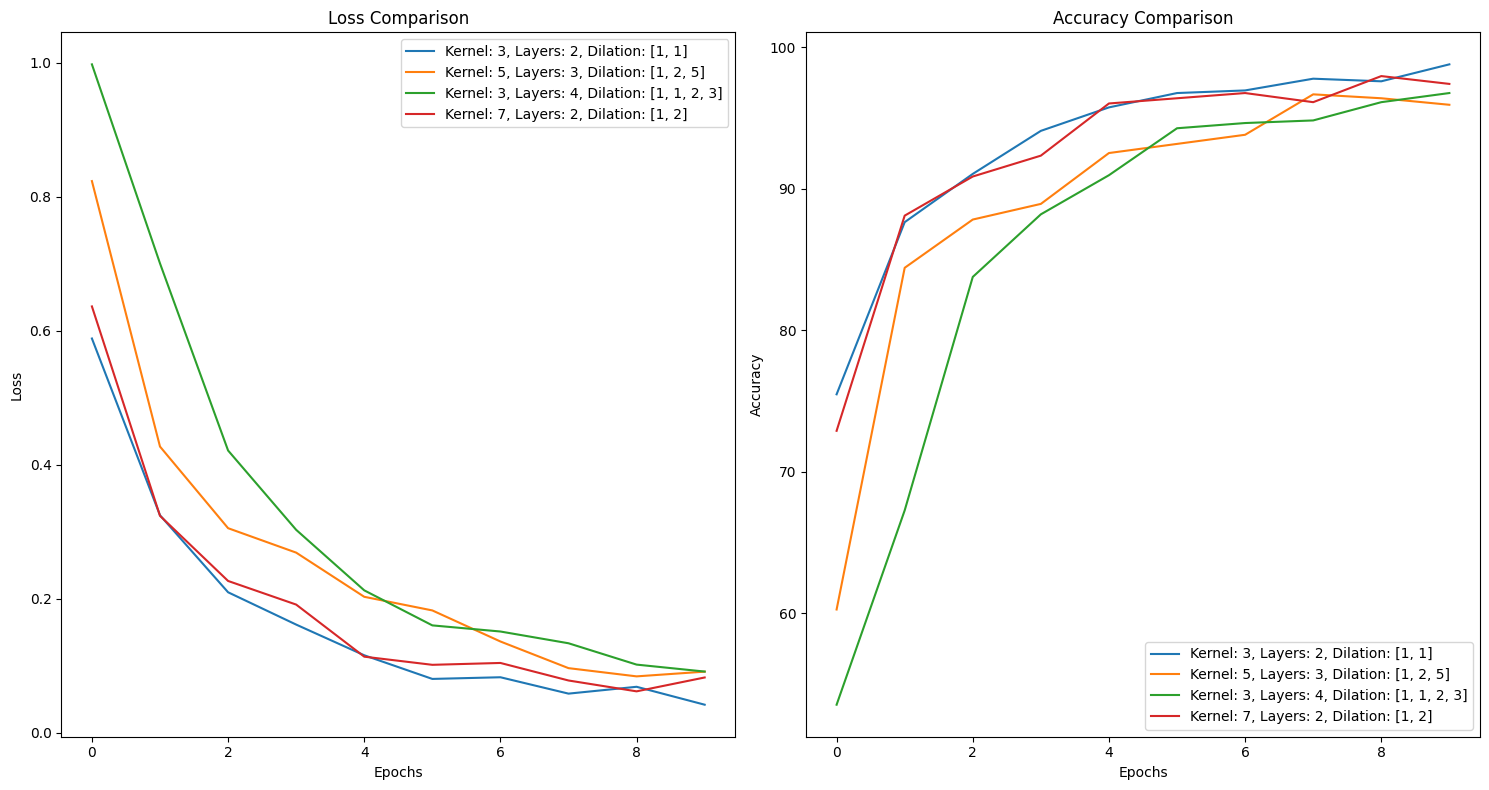

In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# 数据加载与预处理
class VehicleDataset(data.Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label

# 预处理步骤，包括调整图片大小和归一化
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 加载数据
def load_data(data_dir, test_size=0.2):
    labels = {'car': 0, 'bus': 1, 'truck': 2}
    img_paths = []
    img_labels = []

    # 遍历每个类别
    for label_name, label in labels.items():
        class_path = os.path.join(data_dir, label_name)
        for img_name in os.listdir(class_path):
            # 忽略隐藏文件和非图像文件
            if img_name.startswith('.') or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(class_path, img_name)
            img_paths.append(img_path)
            img_labels.append(label)

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(img_paths, img_labels, test_size=test_size, stratify=img_labels)
    
    train_dataset = VehicleDataset(X_train, y_train, transform)
    test_dataset = VehicleDataset(X_test, y_test, transform)
    
    return train_dataset, test_dataset

# 定义卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self, kernel_size=3, num_conv_layers=2, dilation_rates=None):
        super(ConvNet, self).__init__()
        self.num_conv_layers = num_conv_layers
        
        self.conv_layers = nn.ModuleList()
        
        in_channels = 3
        out_channels = 64
        
        # 卷积层
        for i in range(num_conv_layers):
            dilation = dilation_rates[i] if dilation_rates else 1
            self.conv_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=dilation, dilation=dilation)
            )
            in_channels = out_channels
            out_channels *= 2
        
        # 池化层
        self.pool = nn.MaxPool2d(2, 2)
        
        # 计算卷积层输出的尺寸
        self._to_linear = None
        self._calculate_conv_output_size()
        
        # 全连接层
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 3)  # 3个类别

    def _calculate_conv_output_size(self):
        # 创建一个虚拟输入，尺寸是(1, 3, 128, 128) 表示1张128x128的RGB图像
        with torch.no_grad():
            x = torch.ones(1, 3, 128, 128)
            for conv in self.conv_layers:
                x = conv(x)
                x = self.pool(x)
            # 获取经过所有卷积层和池化层后的尺寸
            self._to_linear = x.numel()

    def forward(self, x):
        for conv in self.conv_layers:
            x = self.pool(torch.relu(conv(x)))  # 卷积 + ReLU + 池化
        x = x.view(x.size(0), -1)  # 展开为全连接层的输入
        x = torch.relu(self.fc1(x))  # 全连接层 + ReLU
        x = self.fc2(x)  # 输出层
        return x

# 训练模型
def train_model(train_loader, test_loader, model, criterion, optimizer, epochs=5):
    loss_history = []
    accuracy_history = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_samples
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')

    return loss_history, accuracy_history, time.time() - start_time

# 可视化结果
def plot_comparison_results(loss_dict, accuracy_dict, hyperparameters):
    plt.figure(figsize=(15, 8))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    for param_set, losses in loss_dict.items():
        plt.plot(losses, label=f'Kernel: {param_set[0]}, Layers: {param_set[1]}, Dilation: {param_set[2]}')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    for param_set, accuracies in accuracy_dict.items():
        plt.plot(accuracies, label=f'Kernel: {param_set[0]}, Layers: {param_set[1]}, Dilation: {param_set[2]}')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 设置数据集路径
data_dir = r"C:\Users\37623\jupyter_test\Lab4\datasets\Vehicle_classification_dataset"

# 加载数据
train_dataset, test_dataset = load_data(data_dir)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 超参数配置
param_sets = [
    (3, 2, [1, 1]),  # kernel_size=3, 2 layers, dilation=[1,1]
    (5, 3, [1, 2, 5]),  # kernel_size=5, 3 layers, dilation=[1, 2, 5]
    (3, 4, [1, 1, 2, 3]),  # kernel_size=3, 4 layers, dilation=[1, 1, 2, 3]
    (7, 2, [1, 2]),  # kernel_size=7, 2 layers, dilation=[1, 2]
]

loss_dict = {}
accuracy_dict = {}

# 训练每个超参数配置
for kernel_size, num_layers, dilation_rates in param_sets:
    model = ConvNet(kernel_size=kernel_size, num_conv_layers=num_layers, dilation_rates=dilation_rates)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    
    print(f"\nTraining model with Kernel Size: {kernel_size}, Layers: {num_layers}, Dilation Rates: {dilation_rates}")
    loss_history, accuracy_history, training_time = train_model(
        train_loader, test_loader, model, criterion, optimizer, epochs=10
    )
    
    param_set = (kernel_size, num_layers, str(dilation_rates))
    loss_dict[param_set] = loss_history
    accuracy_dict[param_set] = accuracy_history

# 绘制所有超参数配置下的对比图
plot_comparison_results(loss_dict, accuracy_dict, param_sets)
